# Advanced Exercise project 4 – RNN/LSTM for time series forecasting (Multivariate input)

This notebook attempts to improve the previous models by implementing a Multivariate LSTM model to predict Global Active Power using both Global Active Power and Global Intensity as input features. The goal was to see if combining these features would lead to improved predictions.

https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption


### Step 0: Importing libraries and loading the dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm.keras import TqdmCallback

seed = 101
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_4/"
os.chdir(folder_path)

In [ ]:
df_txt = pd.read_csv("data/household_power_consumption.txt", sep=";", na_values="NaN", low_memory=False)

### Step 1: Data analysis and visualisations

In [ ]:
df_txt['datetime'] = pd.to_datetime(df_txt['Date'] + ' ' + df_txt['Time'])
df_txt.drop(columns=['Date', 'Time'], inplace=True)

In [ ]:
df = df_txt

In [ ]:
df = df.sort_values(by='datetime')
df.columns = df.columns.str.lower()
df.head(5)

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,datetime
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,2006-12-16 17:28:00


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.reset_index(inplace=True)
df = df[['datetime', 'global_active_power', 'global_intensity']]
df.head(2)

,datetime,global_active_power,global_intensity
0,2006-12-16 17:24:00,4.216,18.400
1,2006-12-16 17:25:00,5.360,23.000


In [ ]:
df['global_active_power'] = pd.to_numeric(df['global_active_power'], errors='coerce')
df['global_intensity'] = pd.to_numeric(df['global_intensity'], errors='coerce')
df.dropna(subset=['global_active_power', 'global_intensity'], inplace=True)

In [ ]:
df.set_index('datetime', inplace=True)

In [ ]:
df_resampled = df.resample('D').mean()
df_resampled.dropna(inplace=True)

In [ ]:
df_resampled.dropna(inplace=True)
df_resampled.isna().sum()

,0
global_active_power,0
global_intensity,0


In [ ]:
df_resampled.head()

,global_active_power,global_intensity
datetime,,
2006-12-16,3.053475,13.082828
2006-12-17,2.354486,9.999028
2006-12-18,1.530435,6.421667
2006-12-19,1.157079,4.926389
2006-12-20,1.545658,6.467361


In [ ]:
df_resampled = df_resampled.reset_index()

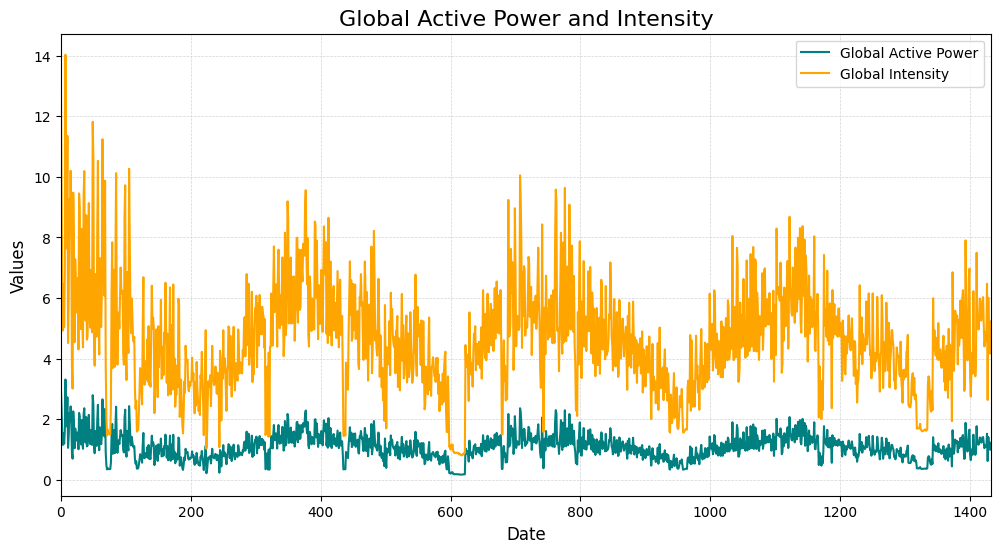

In [ ]:
plt.figure(figsize=(12, 6))

# Plot both columns
plt.plot(df_resampled.index, df_resampled['global_active_power'], color='teal', label='Global Active Power', linewidth=1.5)
plt.plot(df_resampled.index, df_resampled['global_intensity'], color='orange', label='Global Intensity', linewidth=1.5)

# Add titles and labels
plt.title('Global Active Power and Intensity', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Fix x-axis limits
plt.xlim(df_resampled.index.min(), df_resampled.index.max())

# Add grid, legend, and format
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend(fontsize=10)

# Show the plot
plt.show()


In [ ]:
df_resampled = df_resampled.reset_index()  # Reset index after resampling
df_resampled.head(2)

,index,datetime,global_active_power,global_intensity
0,0,2006-12-16,3.053475,13.082828
1,1,2006-12-17,2.354486,9.999028


### Step 2: Data pre-processing

In [ ]:
data_inputs = df_resampled[['global_active_power', 'global_intensity']].values
data_target = df_resampled[['global_active_power']].values

In [ ]:
scaler_inputs = MinMaxScaler(feature_range=(0.01, 1))
scaler_target = MinMaxScaler(feature_range=(0.01, 1))

In [ ]:
data_inputs_normalized = scaler_inputs.fit_transform(data_inputs)
data_target_normalized = scaler_target.fit_transform(data_target)

In [ ]:
train_size = int(len(data_inputs_normalized) * 0.8)
train_inputs = data_inputs_normalized[:train_size]
train_target = data_target_normalized[:train_size]
test_inputs = data_inputs_normalized[train_size:]
test_target = data_target_normalized[train_size:]

In [ ]:
TimeseriesGenerator = tf.keras.preprocessing.sequence.TimeseriesGenerator

In [ ]:
# number of previous steps to predict the next one
look_back = 20
n_features = data_inputs_normalized.shape[1]

In [ ]:
train_generator = TimeseriesGenerator(train_inputs, train_target, length=look_back, batch_size=1)
test_generator = TimeseriesGenerator(test_inputs, test_target, length=look_back, batch_size=1)

### Step 3: Model Architecture

In [ ]:
Sequential = tf.keras.models.Sequential
LSTM = tf.keras.layers.LSTM
Dense = tf.keras.layers.Dense

In [ ]:
n_neurons = 50  #  LSTM neurons
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(look_back, n_features)),  # Input layer
    tf.keras.layers.LSTM(n_neurons, activation='relu'),    # LSTM layer
    tf.keras.layers.Dense(1)                               # Dense layer for output
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    train_generator,
    epochs=10,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

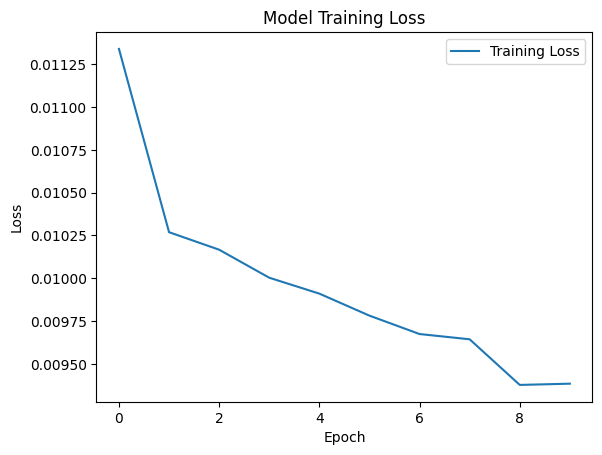

In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Step 4: Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate

In [ ]:
# predictions
train_predictions = model.predict(train_generator)
test_predictions = model.predict(test_generator)

1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
train_predictions_rescaled = scaler_target.inverse_transform(train_predictions)
test_predictions_rescaled = scaler_target.inverse_transform(test_predictions)
train_actual_rescaled = scaler_target.inverse_transform(train_target[look_back:])
test_actual_rescaled = scaler_target.inverse_transform(test_target[look_back:])

In [ ]:
# metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, mse, rmse, r2, mape

In [ ]:
train_metrics = calculate_metrics(train_actual_rescaled, train_predictions_rescaled)
test_metrics = calculate_metrics(test_actual_rescaled, test_predictions_rescaled)

In [ ]:
metrics_data = {
    "Metric": ["MAE", "MSE", "RMSE", "R2", "MAPE"],
    "Train": train_metrics,
    "Test": test_metrics
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Metric,Train,Test
0,MAE,0.227498,0.168434
1,MSE,0.094602,0.057786
2,RMSE,0.307575,0.240387
3,R2,0.472044,0.371798
4,MAPE,22.189853,17.588829


### Step 5: Forcasting

In [ ]:
# last look_back values from the test set
seed_batch = test_inputs[-look_back:].reshape((1, look_back, n_features))
current_batch = seed_batch
future_predictions = []

In [ ]:
for i in range(100):  # 100 future time steps
    # Make prediction
    prediction = model.predict(current_batch, verbose=0)[0]
    future_predictions.append(prediction)

    # Get the last 'global_reactive_power' value
    last_reactive_power = current_batch[0, -1, 1]  # Extract as scalar

    # Create next input with shape (1, 1, n_features)
    next_input = np.array([[prediction[0], last_reactive_power]])  # Shape: (1, 2)
    next_input = next_input.reshape((1, 1, n_features))            # Shape: (1, 1, 2)

    # Update current_batch by removing the first time step and adding next_input
    current_batch = np.concatenate((current_batch[:, 1:, :], next_input), axis=1)


In [ ]:
# rescale predictions back to the original scale
future_predictions_rescaled = scaler_target.inverse_transform(future_predictions)

In [ ]:
df.reset_index(inplace=True)
train_dates = df_resampled['datetime'][look_back:train_size]
test_dates = df_resampled['datetime'][train_size + look_back:]

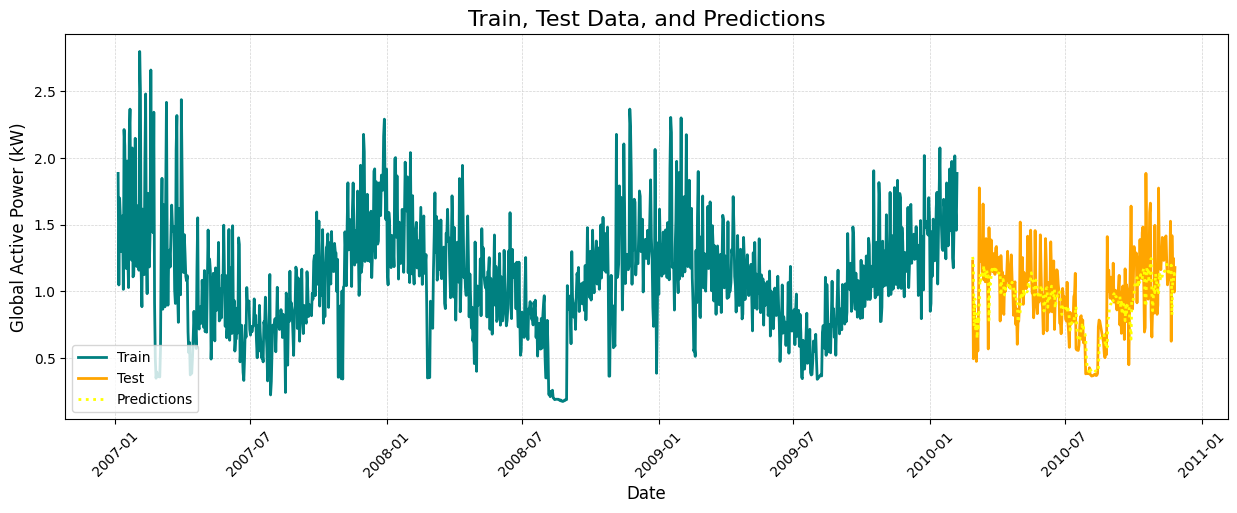

In [ ]:
plt.figure(figsize=(15, 5))
# training data
plt.plot(train_dates, train_actual_rescaled, label='Train', linewidth=2, color='Teal')
# test data
plt.plot(test_dates, test_actual_rescaled, label='Test', linewidth=2, color='orange')
# predictions
plt.plot(test_dates, test_predictions_rescaled, label='Predictions', linestyle=':', linewidth=2, color='yellow')

plt.title("Train, Test Data, and Predictions", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Global Active Power (kW)", fontsize=12)
plt.legend(loc="lower left", fontsize=10)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Show plot
plt.show()

### Personal Analysis / Refelection

Incorporating a second feature (Global Intensity) provided the model with more context, resulting in lower error metrics than the single-variable models. The model achieved an R² score of 0.3718 on the test set, indicating that it captured 37.18% of the variation in the data. The MAE of 0.1684 and MSE of 0.0578 show improved performance compared to previous models. The model still struggles with rapid changes in the data. Increasing the number of neurons or stacking LSTM layers could improve performance. Using Dropout layers could reduce potential overfitting.